# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.system('rm -r runs')
print('removing previos run dir')
writer = SummaryWriter()

removing previos run dir


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-803925e7-2351-6cf2-2533-7a5846988986)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

100%|██████████| 170498071/170498071 [00:09<00:00, 18389424.28it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset) / 16
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(sixteenth_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch  1: Loss = 2.8055 Acc = 0.13 Test_Loss = 2.3744 Test_Acc = 0.14


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


Epoch  2: Loss = 2.2742 Acc = 0.17 Test_Loss = 2.0936 Test_Acc = 0.20


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch  3: Loss = 2.1136 Acc = 0.23 Test_Loss = 2.0026 Test_Acc = 0.26


100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch  4: Loss = 2.0156 Acc = 0.25 Test_Loss = 1.9876 Test_Acc = 0.27


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch  5: Loss = 1.9687 Acc = 0.29 Test_Loss = 1.8245 Test_Acc = 0.32


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch  6: Loss = 1.9250 Acc = 0.29 Test_Loss = 1.7938 Test_Acc = 0.34


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch  7: Loss = 1.8937 Acc = 0.32 Test_Loss = 1.7733 Test_Acc = 0.35


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch  8: Loss = 1.9501 Acc = 0.31 Test_Loss = 1.7236 Test_Acc = 0.37


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch  9: Loss = 1.8609 Acc = 0.35 Test_Loss = 1.6768 Test_Acc = 0.38


100%|██████████| 40/40 [00:05<00:00,  6.84it/s]


Epoch 10: Loss = 1.9193 Acc = 0.36 Test_Loss = 1.6373 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Epoch 11: Loss = 1.8893 Acc = 0.36 Test_Loss = 1.6087 Test_Acc = 0.41


100%|██████████| 40/40 [00:04<00:00,  8.01it/s]


Epoch 12: Loss = 1.8762 Acc = 0.37 Test_Loss = 1.8784 Test_Acc = 0.38


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 13: Loss = 1.8356 Acc = 0.37 Test_Loss = 1.5986 Test_Acc = 0.41


100%|██████████| 40/40 [00:04<00:00,  8.93it/s]


Epoch 14: Loss = 1.7893 Acc = 0.38 Test_Loss = 1.6625 Test_Acc = 0.40


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 15: Loss = 1.6902 Acc = 0.38 Test_Loss = 1.6016 Test_Acc = 0.40


100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


Epoch 16: Loss = 1.7529 Acc = 0.41 Test_Loss = 1.5396 Test_Acc = 0.43


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 17: Loss = 1.6996 Acc = 0.42 Test_Loss = 1.5315 Test_Acc = 0.43


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 18: Loss = 1.6395 Acc = 0.41 Test_Loss = 1.5308 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 11.55it/s]


Epoch 19: Loss = 1.6890 Acc = 0.42 Test_Loss = 1.4967 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.58it/s]


Epoch 20: Loss = 1.7250 Acc = 0.41 Test_Loss = 1.4682 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 21: Loss = 1.6156 Acc = 0.44 Test_Loss = 1.5107 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 22: Loss = 1.7180 Acc = 0.44 Test_Loss = 1.5125 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 23: Loss = 1.6283 Acc = 0.45 Test_Loss = 1.4678 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 24: Loss = 1.5904 Acc = 0.43 Test_Loss = 1.4886 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  9.87it/s]


Epoch 25: Loss = 1.5757 Acc = 0.45 Test_Loss = 1.4908 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 26: Loss = 1.5737 Acc = 0.45 Test_Loss = 1.4989 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Epoch 27: Loss = 1.6081 Acc = 0.44 Test_Loss = 6.6967 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 28: Loss = 1.5576 Acc = 0.44 Test_Loss = 4.6219 Test_Acc = 0.43


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Epoch 29: Loss = 1.6892 Acc = 0.43 Test_Loss = 3.6560 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 30: Loss = 1.5799 Acc = 0.45 Test_Loss = 1.5967 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


Epoch 31: Loss = 1.4847 Acc = 0.47 Test_Loss = 1.4576 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 32: Loss = 1.4940 Acc = 0.47 Test_Loss = 1.5498 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  9.31it/s]


Epoch 33: Loss = 1.5245 Acc = 0.47 Test_Loss = 1.5893 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 34: Loss = 1.4366 Acc = 0.49 Test_Loss = 2.5804 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Epoch 35: Loss = 1.5081 Acc = 0.48 Test_Loss = 1.5013 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


Epoch 36: Loss = 1.4859 Acc = 0.46 Test_Loss = 1.4187 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 37: Loss = 1.6086 Acc = 0.45 Test_Loss = 38.8136 Test_Acc = 0.33


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 38: Loss = 1.9167 Acc = 0.36 Test_Loss = 19.5101 Test_Acc = 0.31


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 39: Loss = 1.7490 Acc = 0.37 Test_Loss = 2.0958 Test_Acc = 0.39


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 40: Loss = 1.6396 Acc = 0.40 Test_Loss = 1.5721 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 41: Loss = 1.5937 Acc = 0.41 Test_Loss = 1.5550 Test_Acc = 0.43


100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Epoch 42: Loss = 1.5600 Acc = 0.43 Test_Loss = 1.5884 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 43: Loss = 1.5685 Acc = 0.45 Test_Loss = 1.4698 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


Epoch 44: Loss = 1.4750 Acc = 0.46 Test_Loss = 1.4324 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 45: Loss = 1.5381 Acc = 0.45 Test_Loss = 1.4625 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 46: Loss = 1.5765 Acc = 0.47 Test_Loss = 1.4936 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


Epoch 47: Loss = 1.4636 Acc = 0.46 Test_Loss = 1.4122 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 48: Loss = 1.4558 Acc = 0.49 Test_Loss = 1.3793 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 49: Loss = 1.3824 Acc = 0.50 Test_Loss = 1.6670 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 10.54it/s]


Epoch 50: Loss = 1.4230 Acc = 0.49 Test_Loss = 1.8285 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 51: Loss = 1.4421 Acc = 0.48 Test_Loss = 1.4339 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 52: Loss = 1.3675 Acc = 0.51 Test_Loss = 1.3148 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Epoch 53: Loss = 1.4305 Acc = 0.49 Test_Loss = 1.3923 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 54: Loss = 1.3647 Acc = 0.52 Test_Loss = 1.3283 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch 55: Loss = 1.3315 Acc = 0.51 Test_Loss = 1.3512 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 12.00it/s]


Epoch 56: Loss = 1.4124 Acc = 0.51 Test_Loss = 5.8097 Test_Acc = 0.41


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 57: Loss = 1.6574 Acc = 0.43 Test_Loss = 2.8174 Test_Acc = 0.39


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 58: Loss = 1.6870 Acc = 0.41 Test_Loss = 9.8832 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Epoch 59: Loss = 1.6578 Acc = 0.46 Test_Loss = 9.4564 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 60: Loss = 1.6542 Acc = 0.45 Test_Loss = 1.7197 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  9.29it/s]


Epoch 61: Loss = 1.5489 Acc = 0.47 Test_Loss = 1.4420 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 62: Loss = 1.5383 Acc = 0.47 Test_Loss = 1.3962 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


Epoch 63: Loss = 1.5293 Acc = 0.48 Test_Loss = 1.4469 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 64: Loss = 1.5840 Acc = 0.47 Test_Loss = 1.4557 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Epoch 65: Loss = 1.4278 Acc = 0.49 Test_Loss = 1.3635 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Epoch 66: Loss = 1.4780 Acc = 0.49 Test_Loss = 1.4077 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 67: Loss = 1.5014 Acc = 0.50 Test_Loss = 1.3786 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 68: Loss = 1.5122 Acc = 0.48 Test_Loss = 1.4319 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 69: Loss = 1.5065 Acc = 0.47 Test_Loss = 1.7904 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


Epoch 70: Loss = 1.4318 Acc = 0.49 Test_Loss = 1.3932 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 71: Loss = 1.4298 Acc = 0.51 Test_Loss = 1.5156 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.25it/s]


Epoch 72: Loss = 1.3604 Acc = 0.52 Test_Loss = 1.6287 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Epoch 73: Loss = 1.3982 Acc = 0.54 Test_Loss = 1.8010 Test_Acc = 0.54


100%|██████████| 40/40 [00:05<00:00,  7.32it/s]


Epoch 74: Loss = 1.3924 Acc = 0.51 Test_Loss = 1.4249 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


Epoch 75: Loss = 1.3905 Acc = 0.52 Test_Loss = 1.7089 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.11it/s]


Epoch 76: Loss = 1.4000 Acc = 0.53 Test_Loss = 1.3984 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 77: Loss = 1.4684 Acc = 0.51 Test_Loss = 4.1708 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Epoch 78: Loss = 1.4835 Acc = 0.49 Test_Loss = 46.1270 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Epoch 79: Loss = 1.5319 Acc = 0.51 Test_Loss = 6.6872 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 80: Loss = 1.4944 Acc = 0.51 Test_Loss = 1.7115 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.98it/s]


Epoch 81: Loss = 1.6022 Acc = 0.48 Test_Loss = 1.4060 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


Epoch 82: Loss = 1.4421 Acc = 0.49 Test_Loss = 1.3858 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 83: Loss = 1.3676 Acc = 0.51 Test_Loss = 1.5193 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


Epoch 84: Loss = 1.3464 Acc = 0.54 Test_Loss = 5.3228 Test_Acc = 0.53


100%|██████████| 40/40 [00:07<00:00,  5.49it/s]


Epoch 85: Loss = 1.2959 Acc = 0.54 Test_Loss = 1.8114 Test_Acc = 0.53


100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


Epoch 86: Loss = 1.3713 Acc = 0.54 Test_Loss = 1.4607 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Epoch 87: Loss = 1.3517 Acc = 0.53 Test_Loss = 1.4290 Test_Acc = 0.51


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


Epoch 88: Loss = 1.3571 Acc = 0.53 Test_Loss = 2.9699 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 10.15it/s]


Epoch 89: Loss = 1.3324 Acc = 0.54 Test_Loss = 1.8881 Test_Acc = 0.55


100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


Epoch 90: Loss = 1.4185 Acc = 0.53 Test_Loss = 1.9010 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Epoch 91: Loss = 1.4444 Acc = 0.54 Test_Loss = 1.2542 Test_Acc = 0.56


100%|██████████| 40/40 [00:04<00:00,  8.27it/s]


Epoch 92: Loss = 1.3291 Acc = 0.55 Test_Loss = 10.1522 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.48it/s]


Epoch 93: Loss = 1.3807 Acc = 0.53 Test_Loss = 7.0944 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


Epoch 94: Loss = 1.3247 Acc = 0.53 Test_Loss = 2.6828 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


Epoch 95: Loss = 1.3220 Acc = 0.54 Test_Loss = 2.0288 Test_Acc = 0.54


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch 96: Loss = 1.3222 Acc = 0.54 Test_Loss = 2.7818 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Epoch 97: Loss = 1.3013 Acc = 0.56 Test_Loss = 2.3581 Test_Acc = 0.56


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Epoch 98: Loss = 1.3375 Acc = 0.54 Test_Loss = 2.3592 Test_Acc = 0.36


100%|██████████| 40/40 [00:03<00:00, 10.47it/s]


Epoch 99: Loss = 1.4140 Acc = 0.50 Test_Loss = 1.5404 Test_Acc = 0.47


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Epoch 100: Loss = 1.5793 Acc = 0.50 Test_Loss = 11.8411 Test_Acc = 0.43


100%|██████████| 40/40 [00:03<00:00, 10.73it/s]


Epoch 101: Loss = 1.5178 Acc = 0.49 Test_Loss = 4.3737 Test_Acc = 0.40


100%|██████████| 40/40 [00:05<00:00,  7.83it/s]


Epoch 102: Loss = 1.4849 Acc = 0.48 Test_Loss = 2.8270 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Epoch 103: Loss = 1.3882 Acc = 0.52 Test_Loss = 1.3125 Test_Acc = 0.52


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Epoch 104: Loss = 1.3192 Acc = 0.52 Test_Loss = 1.3034 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 105: Loss = 1.4178 Acc = 0.53 Test_Loss = 1.4099 Test_Acc = 0.53


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch 106: Loss = 1.3374 Acc = 0.53 Test_Loss = 1.6987 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 10.47it/s]


Epoch 107: Loss = 1.3508 Acc = 0.53 Test_Loss = 1.8527 Test_Acc = 0.56


100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 108: Loss = 1.3378 Acc = 0.55 Test_Loss = 1.6630 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


Epoch 109: Loss = 1.5171 Acc = 0.51 Test_Loss = 1.3796 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.00it/s]


Epoch 110: Loss = 1.9380 Acc = 0.37 Test_Loss = 2.2515 Test_Acc = 0.21


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 111: Loss = 2.0341 Acc = 0.30 Test_Loss = 359.9148 Test_Acc = 0.14


100%|██████████| 40/40 [00:05<00:00,  7.94it/s]


Epoch 112: Loss = 1.9625 Acc = 0.32 Test_Loss = 3.3232 Test_Acc = 0.32


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 113: Loss = 1.8078 Acc = 0.37 Test_Loss = 1.8041 Test_Acc = 0.38


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch 114: Loss = 1.8422 Acc = 0.36 Test_Loss = 1.7702 Test_Acc = 0.35


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 115: Loss = 1.8118 Acc = 0.36 Test_Loss = 1.6730 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 116: Loss = 1.7122 Acc = 0.39 Test_Loss = 1.5713 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 117: Loss = 1.7032 Acc = 0.40 Test_Loss = 1.5812 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


Epoch 118: Loss = 1.5831 Acc = 0.43 Test_Loss = 1.5526 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 119: Loss = 1.5315 Acc = 0.44 Test_Loss = 1.5022 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 120: Loss = 1.5009 Acc = 0.46 Test_Loss = 1.4609 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.38it/s]


Epoch 121: Loss = 1.4903 Acc = 0.47 Test_Loss = 1.5234 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 122: Loss = 1.5304 Acc = 0.46 Test_Loss = 1.4409 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 123: Loss = 1.4906 Acc = 0.47 Test_Loss = 1.3924 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 124: Loss = 1.5304 Acc = 0.48 Test_Loss = 1.3810 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


Epoch 125: Loss = 1.5679 Acc = 0.48 Test_Loss = 1.4113 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 126: Loss = 1.5702 Acc = 0.45 Test_Loss = 1.4580 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Epoch 127: Loss = 1.4636 Acc = 0.48 Test_Loss = 1.3521 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 128: Loss = 1.5148 Acc = 0.48 Test_Loss = 1.3199 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 129: Loss = 1.4559 Acc = 0.49 Test_Loss = 1.3368 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 130: Loss = 1.4372 Acc = 0.51 Test_Loss = 1.3542 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


Epoch 131: Loss = 1.3867 Acc = 0.51 Test_Loss = 2.4546 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 132: Loss = 1.4817 Acc = 0.48 Test_Loss = 1.6192 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


Epoch 133: Loss = 1.4155 Acc = 0.50 Test_Loss = 1.4258 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 134: Loss = 1.5493 Acc = 0.44 Test_Loss = 2.0029 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 10.40it/s]


Epoch 135: Loss = 1.4965 Acc = 0.47 Test_Loss = 1.4383 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 136: Loss = 1.4192 Acc = 0.50 Test_Loss = 1.3910 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 137: Loss = 1.5501 Acc = 0.49 Test_Loss = 3.3733 Test_Acc = 0.37


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 138: Loss = 1.9075 Acc = 0.31 Test_Loss = 22.0557 Test_Acc = 0.23


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 139: Loss = 1.8235 Acc = 0.35 Test_Loss = 1.9650 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 140: Loss = 1.6866 Acc = 0.41 Test_Loss = 1.6729 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 141: Loss = 1.5593 Acc = 0.42 Test_Loss = 1.5103 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch 142: Loss = 1.5839 Acc = 0.44 Test_Loss = 1.4327 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 143: Loss = 1.5267 Acc = 0.44 Test_Loss = 1.5201 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 144: Loss = 1.4926 Acc = 0.46 Test_Loss = 1.4729 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Epoch 145: Loss = 1.5182 Acc = 0.46 Test_Loss = 1.4116 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 146: Loss = 1.4234 Acc = 0.50 Test_Loss = 1.3989 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 147: Loss = 1.4529 Acc = 0.48 Test_Loss = 1.4153 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


Epoch 148: Loss = 1.4396 Acc = 0.50 Test_Loss = 1.3368 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 149: Loss = 1.4111 Acc = 0.51 Test_Loss = 1.2817 Test_Acc = 0.54


100%|██████████| 40/40 [00:04<00:00,  8.16it/s]


Epoch 150: Loss = 1.3759 Acc = 0.53 Test_Loss = 1.2990 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Epoch 151: Loss = 1.2825 Acc = 0.54 Test_Loss = 1.2952 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.19it/s]


Epoch 152: Loss = 1.3604 Acc = 0.53 Test_Loss = 1.3018 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 153: Loss = 1.2992 Acc = 0.54 Test_Loss = 1.2604 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch 154: Loss = 1.3450 Acc = 0.54 Test_Loss = 1.2239 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 155: Loss = 1.3215 Acc = 0.54 Test_Loss = 1.2470 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Epoch 156: Loss = 1.2484 Acc = 0.56 Test_Loss = 1.3182 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 157: Loss = 1.2663 Acc = 0.55 Test_Loss = 1.4110 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 158: Loss = 1.2967 Acc = 0.54 Test_Loss = 1.6128 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 159: Loss = 1.3056 Acc = 0.55 Test_Loss = 1.2779 Test_Acc = 0.56


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


Epoch 160: Loss = 1.2792 Acc = 0.57 Test_Loss = 1.4895 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 161: Loss = 1.3214 Acc = 0.54 Test_Loss = 1.3210 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 162: Loss = 1.2873 Acc = 0.56 Test_Loss = 1.3870 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 163: Loss = 1.3183 Acc = 0.56 Test_Loss = 1.2544 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 164: Loss = 1.2370 Acc = 0.58 Test_Loss = 1.1659 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 165: Loss = 1.2313 Acc = 0.57 Test_Loss = 1.1791 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 10.87it/s]


Epoch 166: Loss = 1.2517 Acc = 0.57 Test_Loss = 1.1246 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  8.88it/s]


Epoch 167: Loss = 1.2962 Acc = 0.55 Test_Loss = 1.2389 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 168: Loss = 1.4587 Acc = 0.49 Test_Loss = 1.5655 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch 169: Loss = 1.3699 Acc = 0.51 Test_Loss = 1.3701 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 170: Loss = 1.3685 Acc = 0.52 Test_Loss = 1.2569 Test_Acc = 0.54


100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 171: Loss = 1.2671 Acc = 0.53 Test_Loss = 1.2008 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 172: Loss = 1.2486 Acc = 0.55 Test_Loss = 1.1638 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Epoch 173: Loss = 1.2707 Acc = 0.57 Test_Loss = 1.1706 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 174: Loss = 1.2117 Acc = 0.58 Test_Loss = 1.1790 Test_Acc = 0.58


100%|██████████| 40/40 [00:04<00:00,  8.12it/s]


Epoch 175: Loss = 1.2191 Acc = 0.57 Test_Loss = 1.2021 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


Epoch 176: Loss = 1.1612 Acc = 0.59 Test_Loss = 1.3497 Test_Acc = 0.60


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


Epoch 177: Loss = 1.2017 Acc = 0.58 Test_Loss = 1.2299 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


Epoch 178: Loss = 1.2149 Acc = 0.58 Test_Loss = 1.2736 Test_Acc = 0.57


100%|██████████| 40/40 [00:05<00:00,  7.92it/s]


Epoch 179: Loss = 1.1793 Acc = 0.58 Test_Loss = 1.3443 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 180: Loss = 1.3119 Acc = 0.57 Test_Loss = 1.2480 Test_Acc = 0.56


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch 181: Loss = 1.3094 Acc = 0.56 Test_Loss = 1.2734 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


Epoch 182: Loss = 1.3473 Acc = 0.55 Test_Loss = 8.1044 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


Epoch 183: Loss = 1.2333 Acc = 0.56 Test_Loss = 1.2100 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


Epoch 184: Loss = 1.2162 Acc = 0.58 Test_Loss = 1.1917 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 185: Loss = 1.1579 Acc = 0.59 Test_Loss = 1.5780 Test_Acc = 0.58


100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


Epoch 186: Loss = 1.1689 Acc = 0.60 Test_Loss = 1.1030 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Epoch 187: Loss = 1.1952 Acc = 0.59 Test_Loss = 1.1158 Test_Acc = 0.60


100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 188: Loss = 1.1918 Acc = 0.59 Test_Loss = 1.2493 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 189: Loss = 1.2399 Acc = 0.55 Test_Loss = 1.7810 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Epoch 190: Loss = 1.1884 Acc = 0.58 Test_Loss = 1.1987 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 191: Loss = 1.1785 Acc = 0.58 Test_Loss = 1.1545 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch 192: Loss = 1.2285 Acc = 0.59 Test_Loss = 1.1284 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 193: Loss = 1.1451 Acc = 0.60 Test_Loss = 1.0867 Test_Acc = 0.61


100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


Epoch 194: Loss = 1.1775 Acc = 0.60 Test_Loss = 1.1097 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 195: Loss = 1.1837 Acc = 0.60 Test_Loss = 1.3088 Test_Acc = 0.60


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch 196: Loss = 1.0923 Acc = 0.60 Test_Loss = 1.0924 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 197: Loss = 1.0555 Acc = 0.62 Test_Loss = 1.1208 Test_Acc = 0.62


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


Epoch 198: Loss = 1.1988 Acc = 0.61 Test_Loss = 45.0385 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 199: Loss = 1.2462 Acc = 0.57 Test_Loss = 5.5498 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.67it/s]

Epoch 200: Loss = 1.2130 Acc = 0.58 Test_Loss = 1.3288 Test_Acc = 0.59


In [ ]:
print(best_acc)

0.6161


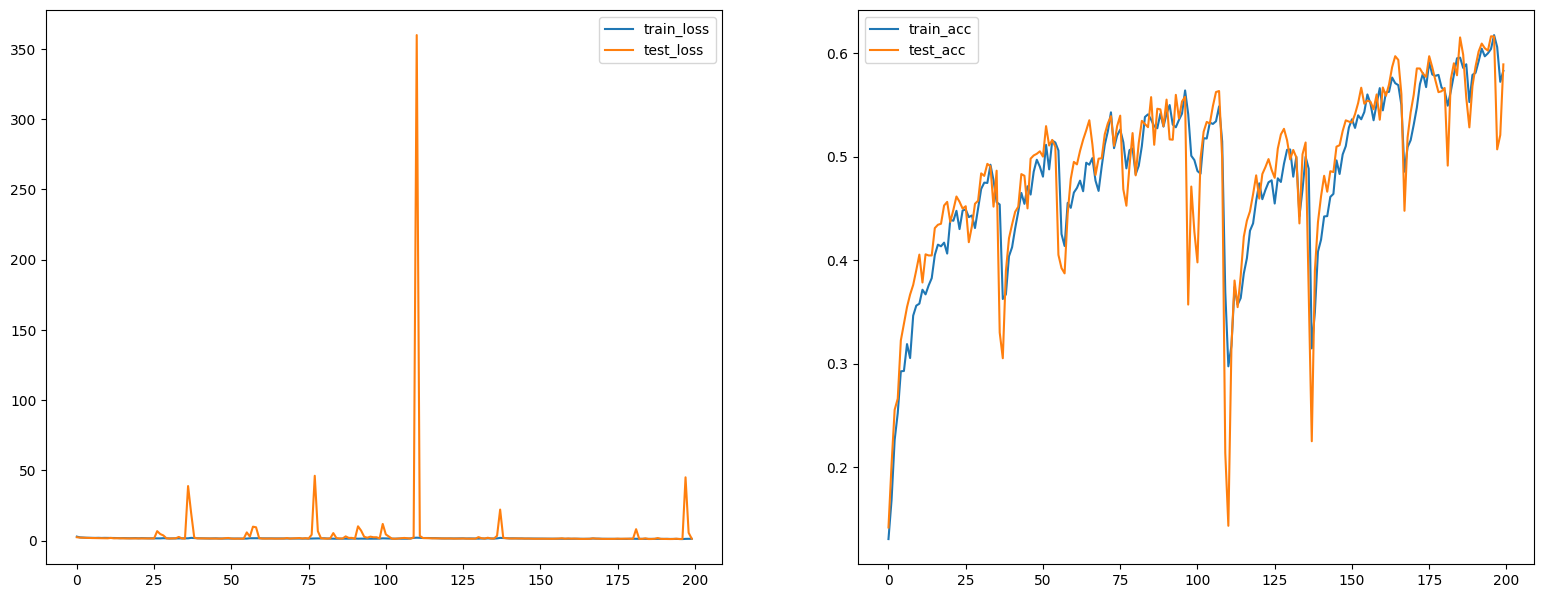

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(sixteenth_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch  1: Loss = 1.9264 Acc = 0.33 Test_Loss = 5.1163 Test_Acc = 0.26


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch  2: Loss = 1.4099 Acc = 0.51 Test_Loss = 5.4730 Test_Acc = 0.36


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch  3: Loss = 1.1946 Acc = 0.58 Test_Loss = 1.8225 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.39it/s]


Epoch  4: Loss = 1.0925 Acc = 0.62 Test_Loss = 1.1502 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch  5: Loss = 1.0186 Acc = 0.66 Test_Loss = 1.1024 Test_Acc = 0.66


100%|██████████| 40/40 [00:06<00:00,  6.31it/s]


Epoch  6: Loss = 0.9617 Acc = 0.69 Test_Loss = 0.9195 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch  7: Loss = 0.9247 Acc = 0.69 Test_Loss = 0.9132 Test_Acc = 0.69


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch  8: Loss = 0.9280 Acc = 0.68 Test_Loss = 1.1634 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch  9: Loss = 0.9042 Acc = 0.68 Test_Loss = 0.8232 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 10: Loss = 0.8475 Acc = 0.71 Test_Loss = 1.0438 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 11: Loss = 0.8456 Acc = 0.72 Test_Loss = 0.8194 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Epoch 12: Loss = 0.8309 Acc = 0.73 Test_Loss = 0.7608 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 13: Loss = 0.8047 Acc = 0.73 Test_Loss = 0.7665 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Epoch 14: Loss = 0.8071 Acc = 0.74 Test_Loss = 0.8232 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 15: Loss = 0.7640 Acc = 0.73 Test_Loss = 0.7793 Test_Acc = 0.74


100%|██████████| 40/40 [00:05<00:00,  7.91it/s]


Epoch 16: Loss = 0.7208 Acc = 0.76 Test_Loss = 0.7593 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 17: Loss = 0.8045 Acc = 0.73 Test_Loss = 0.7941 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 18: Loss = 0.7582 Acc = 0.75 Test_Loss = 0.8076 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 19: Loss = 0.7185 Acc = 0.74 Test_Loss = 0.8224 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 20: Loss = 0.7136 Acc = 0.76 Test_Loss = 0.7688 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


Epoch 21: Loss = 0.7088 Acc = 0.74 Test_Loss = 0.8076 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Epoch 22: Loss = 0.7376 Acc = 0.75 Test_Loss = 0.7626 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch 23: Loss = 0.7082 Acc = 0.77 Test_Loss = 0.7429 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 24: Loss = 0.7115 Acc = 0.77 Test_Loss = 0.7511 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch 25: Loss = 0.6955 Acc = 0.76 Test_Loss = 0.7143 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 26: Loss = 0.6545 Acc = 0.78 Test_Loss = 0.7500 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch 27: Loss = 0.6807 Acc = 0.76 Test_Loss = 1.0015 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 28: Loss = 0.6980 Acc = 0.77 Test_Loss = 0.6955 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 29: Loss = 0.6505 Acc = 0.79 Test_Loss = 0.8081 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 30: Loss = 0.7132 Acc = 0.76 Test_Loss = 0.7943 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


Epoch 31: Loss = 0.7158 Acc = 0.77 Test_Loss = 0.8026 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 32: Loss = 0.7584 Acc = 0.76 Test_Loss = 0.7494 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 33: Loss = 0.6910 Acc = 0.77 Test_Loss = 0.9342 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


Epoch 34: Loss = 0.6755 Acc = 0.77 Test_Loss = 0.7894 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 35: Loss = 0.6827 Acc = 0.77 Test_Loss = 0.7133 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 36: Loss = 0.6474 Acc = 0.77 Test_Loss = 0.6389 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 37: Loss = 0.6558 Acc = 0.78 Test_Loss = 0.8050 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  8.87it/s]


Epoch 38: Loss = 0.6427 Acc = 0.78 Test_Loss = 0.7469 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 39: Loss = 0.6373 Acc = 0.79 Test_Loss = 0.6515 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch 40: Loss = 0.6216 Acc = 0.79 Test_Loss = 0.7042 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 41: Loss = 0.6369 Acc = 0.78 Test_Loss = 0.6483 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 42: Loss = 0.7063 Acc = 0.76 Test_Loss = 0.6446 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 43: Loss = 0.6384 Acc = 0.78 Test_Loss = 0.6923 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch 44: Loss = 0.5995 Acc = 0.79 Test_Loss = 0.6214 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 45: Loss = 0.5444 Acc = 0.81 Test_Loss = 0.6119 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 46: Loss = 0.5617 Acc = 0.80 Test_Loss = 0.5822 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 47: Loss = 0.5993 Acc = 0.80 Test_Loss = 0.6196 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 48: Loss = 0.5550 Acc = 0.82 Test_Loss = 0.6178 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Epoch 49: Loss = 0.5587 Acc = 0.80 Test_Loss = 0.5927 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 50: Loss = 0.5354 Acc = 0.82 Test_Loss = 0.6783 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 51: Loss = 0.5299 Acc = 0.81 Test_Loss = 0.6526 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 52: Loss = 0.6001 Acc = 0.80 Test_Loss = 0.5880 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Epoch 53: Loss = 0.5632 Acc = 0.81 Test_Loss = 0.5584 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 54: Loss = 0.5193 Acc = 0.82 Test_Loss = 0.5639 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 55: Loss = 0.5142 Acc = 0.82 Test_Loss = 0.6636 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 56: Loss = 0.6045 Acc = 0.82 Test_Loss = 1.0898 Test_Acc = 0.68


100%|██████████| 40/40 [00:05<00:00,  7.53it/s]


Epoch 57: Loss = 1.1224 Acc = 0.65 Test_Loss = 3.8807 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 58: Loss = 1.0139 Acc = 0.65 Test_Loss = 3.8332 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 59: Loss = 0.9426 Acc = 0.70 Test_Loss = 1.4187 Test_Acc = 0.68


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 60: Loss = 0.8895 Acc = 0.70 Test_Loss = 0.8632 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch 61: Loss = 0.8088 Acc = 0.73 Test_Loss = 0.8997 Test_Acc = 0.69


100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


Epoch 62: Loss = 0.7115 Acc = 0.76 Test_Loss = 0.7168 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


Epoch 63: Loss = 0.7167 Acc = 0.75 Test_Loss = 0.6869 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Epoch 64: Loss = 0.6514 Acc = 0.78 Test_Loss = 0.6360 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 65: Loss = 0.6264 Acc = 0.78 Test_Loss = 0.6548 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 66: Loss = 0.6201 Acc = 0.79 Test_Loss = 0.6701 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


Epoch 67: Loss = 0.5875 Acc = 0.80 Test_Loss = 0.6387 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 68: Loss = 0.5926 Acc = 0.80 Test_Loss = 0.6281 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 69: Loss = 0.5501 Acc = 0.80 Test_Loss = 0.6180 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Epoch 70: Loss = 0.5767 Acc = 0.80 Test_Loss = 0.6133 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 71: Loss = 0.5626 Acc = 0.80 Test_Loss = 0.6407 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch 72: Loss = 0.6234 Acc = 0.81 Test_Loss = 0.5963 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 73: Loss = 0.5829 Acc = 0.80 Test_Loss = 0.6051 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 74: Loss = 0.5665 Acc = 0.80 Test_Loss = 0.6488 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 75: Loss = 0.5445 Acc = 0.81 Test_Loss = 0.6100 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.77it/s]


Epoch 76: Loss = 0.5502 Acc = 0.81 Test_Loss = 0.5954 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 77: Loss = 0.5528 Acc = 0.82 Test_Loss = 0.6179 Test_Acc = 0.79


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 78: Loss = 0.5095 Acc = 0.83 Test_Loss = 0.5570 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 79: Loss = 0.5278 Acc = 0.82 Test_Loss = 0.5981 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Epoch 80: Loss = 0.5330 Acc = 0.81 Test_Loss = 0.6636 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 81: Loss = 0.5144 Acc = 0.82 Test_Loss = 0.5870 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 82: Loss = 0.5153 Acc = 0.82 Test_Loss = 0.6030 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 83: Loss = 0.5355 Acc = 0.82 Test_Loss = 0.5571 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.59it/s]


Epoch 84: Loss = 0.5100 Acc = 0.82 Test_Loss = 0.5554 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 85: Loss = 0.5342 Acc = 0.82 Test_Loss = 0.5353 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 86: Loss = 0.5293 Acc = 0.82 Test_Loss = 0.5838 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 87: Loss = 0.5209 Acc = 0.82 Test_Loss = 0.5713 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 88: Loss = 0.5092 Acc = 0.83 Test_Loss = 0.5494 Test_Acc = 0.82


100%|██████████| 40/40 [00:05<00:00,  7.00it/s]


Epoch 89: Loss = 0.4955 Acc = 0.83 Test_Loss = 0.5653 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 90: Loss = 0.5226 Acc = 0.82 Test_Loss = 0.5523 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.14it/s]


Epoch 91: Loss = 0.5163 Acc = 0.83 Test_Loss = 0.6409 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 92: Loss = 0.5131 Acc = 0.83 Test_Loss = 0.6333 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Epoch 93: Loss = 0.7005 Acc = 0.79 Test_Loss = 1.2395 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 94: Loss = 0.7221 Acc = 0.77 Test_Loss = 2.1923 Test_Acc = 0.69


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 95: Loss = 0.8428 Acc = 0.74 Test_Loss = 0.9908 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


Epoch 96: Loss = 0.7883 Acc = 0.73 Test_Loss = 1.0014 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


Epoch 97: Loss = 0.7637 Acc = 0.76 Test_Loss = 0.6779 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 98: Loss = 0.6992 Acc = 0.77 Test_Loss = 0.6706 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


Epoch 99: Loss = 0.5918 Acc = 0.79 Test_Loss = 0.6178 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 100: Loss = 0.6143 Acc = 0.80 Test_Loss = 0.6747 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 101: Loss = 0.6402 Acc = 0.78 Test_Loss = 0.8330 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.77it/s]


Epoch 102: Loss = 0.6598 Acc = 0.77 Test_Loss = 0.8241 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


Epoch 103: Loss = 0.6285 Acc = 0.80 Test_Loss = 0.5963 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.86it/s]


Epoch 104: Loss = 0.5878 Acc = 0.80 Test_Loss = 0.6289 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Epoch 105: Loss = 0.5776 Acc = 0.80 Test_Loss = 0.6384 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Epoch 106: Loss = 0.6019 Acc = 0.80 Test_Loss = 0.5798 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 107: Loss = 0.5311 Acc = 0.82 Test_Loss = 0.5587 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 108: Loss = 0.5798 Acc = 0.82 Test_Loss = 0.5552 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 109: Loss = 0.5248 Acc = 0.83 Test_Loss = 0.5734 Test_Acc = 0.81


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


Epoch 110: Loss = 0.5426 Acc = 0.81 Test_Loss = 0.5628 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


Epoch 111: Loss = 0.4913 Acc = 0.83 Test_Loss = 0.5218 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch 112: Loss = 0.4946 Acc = 0.84 Test_Loss = 0.5564 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 113: Loss = 0.5129 Acc = 0.83 Test_Loss = 0.5298 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Epoch 114: Loss = 0.4849 Acc = 0.83 Test_Loss = 0.5474 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 115: Loss = 0.4816 Acc = 0.83 Test_Loss = 0.5373 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


Epoch 116: Loss = 0.5099 Acc = 0.83 Test_Loss = 0.5068 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 117: Loss = 0.5132 Acc = 0.83 Test_Loss = 0.5592 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


Epoch 118: Loss = 0.4616 Acc = 0.85 Test_Loss = 0.5493 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 119: Loss = 0.4486 Acc = 0.84 Test_Loss = 0.5723 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 120: Loss = 0.4466 Acc = 0.84 Test_Loss = 0.5572 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


Epoch 121: Loss = 0.4573 Acc = 0.84 Test_Loss = 0.5160 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 122: Loss = 0.4455 Acc = 0.85 Test_Loss = 0.5326 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


Epoch 123: Loss = 0.4479 Acc = 0.84 Test_Loss = 0.5305 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 124: Loss = 0.4421 Acc = 0.85 Test_Loss = 0.5236 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Epoch 125: Loss = 0.4650 Acc = 0.85 Test_Loss = 0.5138 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 126: Loss = 0.4630 Acc = 0.84 Test_Loss = 0.5330 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 127: Loss = 0.4896 Acc = 0.83 Test_Loss = 0.5040 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 128: Loss = 0.4387 Acc = 0.85 Test_Loss = 0.5211 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.53it/s]


Epoch 129: Loss = 0.4495 Acc = 0.84 Test_Loss = 0.5119 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 130: Loss = 0.4370 Acc = 0.85 Test_Loss = 0.5144 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Epoch 131: Loss = 0.4446 Acc = 0.85 Test_Loss = 0.4848 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 132: Loss = 0.4160 Acc = 0.85 Test_Loss = 0.5000 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 133: Loss = 0.4226 Acc = 0.85 Test_Loss = 0.5192 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 134: Loss = 0.4339 Acc = 0.85 Test_Loss = 0.4891 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


Epoch 135: Loss = 0.4945 Acc = 0.83 Test_Loss = 0.5276 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 136: Loss = 0.4570 Acc = 0.84 Test_Loss = 0.5240 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 137: Loss = 0.4381 Acc = 0.85 Test_Loss = 0.5046 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


Epoch 138: Loss = 0.4163 Acc = 0.86 Test_Loss = 0.5308 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 139: Loss = 0.4291 Acc = 0.85 Test_Loss = 0.5401 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch 140: Loss = 0.4145 Acc = 0.86 Test_Loss = 0.5265 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 141: Loss = 0.4325 Acc = 0.85 Test_Loss = 0.5185 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch 142: Loss = 0.4360 Acc = 0.85 Test_Loss = 0.5038 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 143: Loss = 0.4249 Acc = 0.86 Test_Loss = 0.5118 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.15it/s]


Epoch 144: Loss = 0.4372 Acc = 0.85 Test_Loss = 0.5110 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 145: Loss = 0.4779 Acc = 0.83 Test_Loss = 0.5471 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.46it/s]


Epoch 146: Loss = 0.4108 Acc = 0.85 Test_Loss = 0.5096 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 147: Loss = 0.4397 Acc = 0.86 Test_Loss = 0.5060 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


Epoch 148: Loss = 0.4176 Acc = 0.86 Test_Loss = 0.4847 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 149: Loss = 0.4162 Acc = 0.85 Test_Loss = 0.4718 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


Epoch 150: Loss = 0.4463 Acc = 0.85 Test_Loss = 0.5150 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.50it/s]


Epoch 151: Loss = 0.4224 Acc = 0.85 Test_Loss = 0.5195 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 152: Loss = 0.4225 Acc = 0.84 Test_Loss = 0.5122 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.22it/s]


Epoch 153: Loss = 0.4342 Acc = 0.85 Test_Loss = 0.5257 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


Epoch 154: Loss = 0.3736 Acc = 0.87 Test_Loss = 0.4799 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Epoch 155: Loss = 0.4337 Acc = 0.86 Test_Loss = 0.7794 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.40it/s]


Epoch 156: Loss = 1.4211 Acc = 0.60 Test_Loss = 27.2891 Test_Acc = 0.38


100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Epoch 157: Loss = 1.4026 Acc = 0.54 Test_Loss = 3.2309 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Epoch 158: Loss = 1.4304 Acc = 0.51 Test_Loss = 1.7189 Test_Acc = 0.44


100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Epoch 159: Loss = 1.4116 Acc = 0.51 Test_Loss = 1.3245 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 160: Loss = 1.3629 Acc = 0.54 Test_Loss = 1.3756 Test_Acc = 0.54


100%|██████████| 40/40 [00:06<00:00,  6.50it/s]


Epoch 161: Loss = 1.2660 Acc = 0.56 Test_Loss = 1.3365 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Epoch 162: Loss = 1.2054 Acc = 0.61 Test_Loss = 1.1882 Test_Acc = 0.58


100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Epoch 163: Loss = 1.0910 Acc = 0.62 Test_Loss = 1.1158 Test_Acc = 0.63


100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


Epoch 164: Loss = 1.0303 Acc = 0.64 Test_Loss = 1.0567 Test_Acc = 0.66


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Epoch 165: Loss = 1.0409 Acc = 0.64 Test_Loss = 1.1817 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 166: Loss = 1.0067 Acc = 0.65 Test_Loss = 0.9151 Test_Acc = 0.68


100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


Epoch 167: Loss = 0.8573 Acc = 0.70 Test_Loss = 0.9099 Test_Acc = 0.68


100%|██████████| 40/40 [00:03<00:00, 10.14it/s]


Epoch 168: Loss = 0.8730 Acc = 0.69 Test_Loss = 0.8021 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  8.20it/s]


Epoch 169: Loss = 0.7932 Acc = 0.72 Test_Loss = 0.8504 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


Epoch 170: Loss = 0.8533 Acc = 0.71 Test_Loss = 0.9180 Test_Acc = 0.71


100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Epoch 171: Loss = 0.8093 Acc = 0.73 Test_Loss = 0.7869 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 172: Loss = 0.7910 Acc = 0.72 Test_Loss = 0.7680 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 173: Loss = 0.8088 Acc = 0.73 Test_Loss = 0.7904 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 174: Loss = 0.7017 Acc = 0.75 Test_Loss = 0.9906 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


Epoch 175: Loss = 0.7188 Acc = 0.76 Test_Loss = 0.7574 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


Epoch 176: Loss = 0.7883 Acc = 0.75 Test_Loss = 1.1852 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  8.81it/s]


Epoch 177: Loss = 0.7991 Acc = 0.74 Test_Loss = 0.7315 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch 178: Loss = 0.7356 Acc = 0.77 Test_Loss = 0.7236 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 179: Loss = 0.7027 Acc = 0.77 Test_Loss = 0.6900 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch 180: Loss = 0.7159 Acc = 0.76 Test_Loss = 0.9518 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.10it/s]


Epoch 181: Loss = 0.6894 Acc = 0.76 Test_Loss = 0.6875 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


Epoch 182: Loss = 0.6914 Acc = 0.77 Test_Loss = 0.6717 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


Epoch 183: Loss = 0.7097 Acc = 0.76 Test_Loss = 0.6945 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 184: Loss = 0.6550 Acc = 0.78 Test_Loss = 0.6760 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


Epoch 185: Loss = 0.6538 Acc = 0.79 Test_Loss = 0.6467 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Epoch 186: Loss = 0.6166 Acc = 0.79 Test_Loss = 0.6240 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Epoch 187: Loss = 0.6179 Acc = 0.79 Test_Loss = 0.6182 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 188: Loss = 0.5783 Acc = 0.80 Test_Loss = 0.6310 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch 189: Loss = 0.5700 Acc = 0.80 Test_Loss = 0.6110 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Epoch 190: Loss = 0.5350 Acc = 0.81 Test_Loss = 0.6106 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 191: Loss = 0.5800 Acc = 0.79 Test_Loss = 0.5955 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


Epoch 192: Loss = 0.5448 Acc = 0.81 Test_Loss = 0.6003 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.58it/s]


Epoch 193: Loss = 0.6075 Acc = 0.79 Test_Loss = 0.5847 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 194: Loss = 0.6496 Acc = 0.79 Test_Loss = 0.8878 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 195: Loss = 0.6073 Acc = 0.80 Test_Loss = 0.6767 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.13it/s]


Epoch 196: Loss = 0.5931 Acc = 0.80 Test_Loss = 0.6096 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


Epoch 197: Loss = 0.5357 Acc = 0.82 Test_Loss = 0.6095 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.11it/s]


Epoch 198: Loss = 0.5513 Acc = 0.80 Test_Loss = 0.6206 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.40it/s]


Epoch 199: Loss = 0.5283 Acc = 0.82 Test_Loss = 0.6069 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.03it/s]

Epoch 200: Loss = 0.5170 Acc = 0.82 Test_Loss = 0.5698 Test_Acc = 0.80


In [ ]:
print(best_acc)

0.84


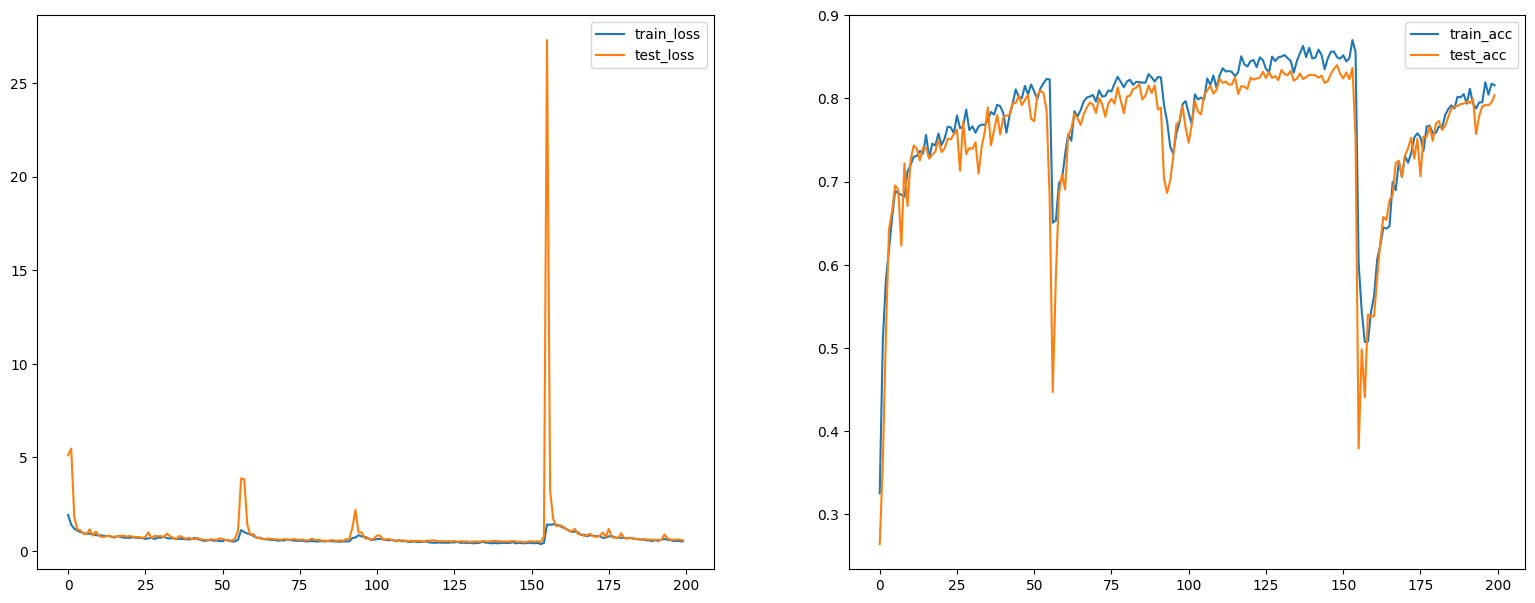

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)